In [1]:
import os
import scenic

# scenic_script = "./examples/carla/ICCV_Scenic_Experiments/5_agent_scenario.scenic"
# # scenic_script = "./examples/carla/dependencyAnalysisTest5.scenic"
# scenario = scenic.scenarioFromFile(scenic_script)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


In [2]:
### Dependency Analysis
def cacheExprTreeNodes(attribute, nodeSet=None):
    """cache all the nodes of the input attribute's expression tree to the dictionary"""
    if nodeSet is None:
        nodeSet = set()
    nodeSet.add(attribute)
    if attribute._dependencies == ():
        return nodeSet
    for dep in attribute._dependencies:
        cacheExprTreeNodes(dep, nodeSet)
    return nodeSet

def cacheAttributes(scenario, attributeList):
    dictionary = {}
    dictionary['objAttributes_names'] = []
    dictionary['positionAttributes_names'] = []
    dictionary['headingAttributes_names'] = []
    
    # cache all object attributes
    for i in range(len(scenario.original_objects)):
        obj = scenario.original_objects[i]
        obj_name = 'obj'+str(i)
        dictionary[obj_name] = {}
        
        for attribute in attributeList:
            dictionary[obj_name][attribute] = {}
            dictionary[obj_name][attribute]['self'] = getattr(obj, attribute)
            dictionary[obj_name][attribute]['set'] = cacheExprTreeNodes(getattr(obj, attribute), None)
            dictionary[obj_name][attribute]['intermediate_variables_set'] = []
            dictionary[obj_name][attribute]['dependent_attribute_names'] = []
            dictionary[obj_name][attribute]['jointly_dependent_attribute_names'] = []
            dictionary[obj_name][attribute]['dependent_attributes_objs'] = set()
            dictionary[obj_name][attribute]['jointly_dependent_attributes_objs'] = set()
            dictionary['objAttributes_names'].append(obj_name+"_"+attribute)
            if attribute == 'position':
                dictionary['positionAttributes_names'].append(obj_name+"_"+attribute)
            if attribute == 'heading':
                dictionary['headingAttributes_names'].append(obj_name+"_"+attribute)
                
    return dictionary

def checkDependenceOnAnotherAttribute(intersection, attr1_name, attr2_name, dictionary):
    """ checks whether the two attr1 and attr2 are jointly dependent on an intermediate variable
    or is both dependent on another attribute. 
    Output:
    True, if attr1 and attr2 are "dependent" on another attribute, not intermediate variable
    False, attr1 and attr2 are both "jointly dependent" on an intermediate variable
    """
    [obj1_name, attr1] = attr1_name.split('_')
    attr1_obj = dictionary[obj1_name][attr1]['self']
    attr1_jointly_dep_attr_names = dictionary[obj1_name][attr1]['jointly_dependent_attribute_names']
    [obj2_name, attr2] = attr2_name.split('_')
    attr2_obj = dictionary[obj2_name][attr2]['self']
    attr2_jointly_dep_attr_names = dictionary[obj2_name][attr2]['jointly_dependent_attribute_names']
#     print("checkDependenceOnAnotherAttribute attr1_name: ", attr1_name)
#     print("checkDependenceOnAnotherAttribute attr2_name: ", attr2_name)
    original_intersection = intersection
    
    objAttributes_names = dictionary['objAttributes_names'] 
    for attr_name in objAttributes_names:
        if attr_name == attr1_name:
            continue
        elif attr_name == attr2_name:
            break
        else:
            [obj_name, attr] = attr_name.split('_')
            attr_obj = dictionary[obj_name][attr]['self']
            attr_depSet = dictionary[obj_name][attr]['dependent_attribute_names']
            
            if attr_obj in original_intersection and attr_name not in attr1_jointly_dep_attr_names \
                and attr_name not in attr2_jointly_dep_attr_names: 
#                 print("other attr_name in the intersection: ", attr_name)
                attr_cachedSet = dictionary[obj_name][attr]['set']
                original_intersection = original_intersection - attr_cachedSet
#                 print("len(original_intersection): ", len(original_intersection))
                if len(original_intersection) == 0:
#                     print("returns True")
                    # the intersection is another attribute
                    return True
    return False
        
def findAttribute(other_attr_obj, attr_dict, dictionary):
    for obj_attr in attr_dict['dependent_attribute_names']:
        [obj, attr] = obj_attr.split("_")
        if other_attr_obj is dictionary[obj][attr]['self']:
            return obj_attr
    return None

def checkIntermediateSetMembership(attr_obj, attrIntermediateList):
    for intermediateSet in attrIntermediateList:
        if attr_obj in intermediateSet:
            return True
    return False

def analysis(objAttributes_names, dictionary):
    for i in range(len(objAttributes_names)):
        for j in range(len(objAttributes_names)):
            if i < j:
                attr1_name = objAttributes_names[i]
                attr2_name = objAttributes_names[j]
                [obj_name1, attr1] = attr1_name.split('_')
                [obj_name2, attr2] = attr2_name.split('_')
        
                attribute1 = dictionary[obj_name1][attr1]
                attribute2 = dictionary[obj_name2][attr2]
                attr1_obj = attribute1['self']
                attr2_obj = attribute2['self']
                
                set1 = attribute1['set']
                set2 = attribute2['set']
                intersection = set1.intersection(set2)
                
                if attr1_obj in intersection and attr1_obj not in attribute2['dependent_attributes_objs']:
                    # attr2_obj is dependent on attr1_obj
                    attribute2['dependent_attribute_names'].append(attr1_name)
                    attribute2['dependent_attributes_objs'].add(attr1_obj)
                elif attr2_obj in intersection and attr2_obj not in attribute1['dependent_attributes_objs']:
                    # jointly_dependent case (e.g. depedendencyAnalysisTest4.scenic)
                    if attr2_name not in attribute1['jointly_dependent_attribute_names']:
                        attribute1['jointly_dependent_attribute_names'].append(attr2_name)
                        attribute1['jointly_dependent_attributes_objs'].add(attr2_obj)     
                        attribute1['intermediate_variables_set'].append(intersection)

                    if attr1_name not in attribute2['jointly_dependent_attribute_names']:
                        attribute2['jointly_dependent_attribute_names'].append(attr1_name)
                        attribute2['jointly_dependent_attributes_objs'].add(attr1_obj)
                        attribute2['intermediate_variables_set'].append(intersection)
                        
                elif len(intersection) > 0 \
                    and attr1_obj not in intersection and attr2_obj not in intersection \
                    and not checkDependenceOnAnotherAttribute(intersection, attr1_name, attr2_name, dictionary):
                    # the two attributes are jointly dependent (i.e. share intermediate variable(s))
                    if attr2_name not in attribute1['jointly_dependent_attribute_names']:
                        attribute1['jointly_dependent_attribute_names'].append(attr2_name)
                        attribute1['jointly_dependent_attributes_objs'].add(attr2_obj)     
                        attribute1['intermediate_variables_set'].append(intersection)
                    
                    if attr1_name not in attribute2['jointly_dependent_attribute_names']:
                        attribute2['jointly_dependent_attribute_names'].append(attr1_name)
                        attribute2['jointly_dependent_attributes_objs'].add(attr1_obj)
                        attribute2['intermediate_variables_set'].append(intersection)

                else:
                    pass
    return dictionary
    
def dependencyAnalysis(scenario, attributeList):
    dictionary = cacheAttributes(scenario, attributeList)
    dictionary['numberOfObjects'] = len(scenario.original_objects)
    objAttributes_names = dictionary['objAttributes_names']
    dictionary = analysis(objAttributes_names, dictionary)
    return dictionary

def sortDependency(dictionary, scenario):
    output = []
    covered_attributes = []
    
    for elem in dictionary['objAttributes_names']:
        if elem in covered_attributes:
            continue
        covered_attributes.append(elem)
        [obj_name, attr_name] = elem.split("_")
        joint_dep_set = dictionary[obj_name][attr_name]['jointly_dependent_attribute_names']
        if len(joint_dep_set) > 0:
            jointly_dependent_list = [elem]
            
            for j in joint_dep_set:
                [j_obj_name, j_attr] = j.split("_")
                jointly_dependent_list.append(j)
                covered_attributes.append(j)
            output.append(jointly_dependent_list)
        else:
            output.append([elem])
    return output

In [3]:
# ## Test Dependency Analysis

# attributeList = ['position', 'heading']
# d = dependencyAnalysis(scenario, attributeList)
# print(sortDependency(d, scenario))

In [4]:
### SMT Translation Pipeline

from scenic.core.regions import SectorRegion
from scenic.core.vectors import OrientedVector, Vector
from scenic.core.distributions import *
import subprocess
import os

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

def resetScenarioDependency(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)
        
def extractLabelAttribute(label, obj_index, attribute_name):
    # Extract specific attribute from a label generated from a scenic program
    return getattr(label.objects[obj_index], attribute_name)

def initializeSMTFile(smt_file_path):
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')
    
def resetDictionary(cached_variables, egoVisibleRegion, smt_file_path):
    cached_variables = {}
    cached_variables['variables'] = []
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    cached_variables['smt_file_path'] = smt_file_path

def translateAttributeExpressionTree(attribute_name, attr_obj, attr_label, cached_variables, \
                                   dictionary, debug=False):
    
    ## TODO: add error bound range to attributes
    smt_file_path = cached_variables['smt_file_path']
    obj_name, attr_type = attribute_name.split("_")

    # Encode the given attribute's expression tree
    smt_var = attr_obj.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    
    if attr_type == 'position':
        assert(isinstance(attr_label, Vector))
        (x_label, y_label) = (str(attr_label.x), str(attr_label.y))
        (x_cond, y_cond) = vector_operation_smt((x_label, y_label), "equal", smt_var)
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(str(attr_label), smt_var)))
            
def conditionAttributes(jointlyDependentAttributeList, dictionary):
    for attribute_name in jointlyDependentAttributeList:
        obj_name, attr_name = attribute_name.split("_")
        obj_index = int(obj_name.split("obj")[1])
        attr_label = extractLabelAttribute(label, obj_index, attr_name)
        attr_obj = dictionary[obj_name][attr_name]['self']
        if isinstance(attr_label, float) or isinstance(attr_label, int):
            print("conditionAttributes attribute: ", attribute_name)
            attr_obj.conditionTo(Constant(attr_label))
        else:
            attr_obj.conditionTo(attr_label)
        
def validateLabelElement(scenario, cached_variables, jointlyDependentAttributeList, dictionary, \
                         debug=False, falseTesting=False):
    
    ## translate jointly dependent attribute expression trees
    for attribute_name in jointlyDependentAttributeList:
        obj_name, attr_name = attribute_name.split("_")
        obj_index = int(obj_name.split("obj")[1])
        attr_label = extractLabelAttribute(label, obj_index, attr_name)
        attr_obj = dictionary[obj_name][attr_name]['self']

        translateAttributeExpressionTree(attribute_name, attr_obj, attr_label, cached_variables, \
                                          dictionary, debug)
    
    smt_file_path = cached_variables['smt_file_path']
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if not debug:
        if subprocess.call("./run_smt_encoding.sh") == 1:
            ## This means that jointly dependent attributes are all valid
            ## so condition attributes 
            conditionAttributes(jointlyDependentAttributeList, dictionary)
            return True
        else:
            return False
        
    print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
    return False

def validateLabel(scenario, label, ego_visibleDistance = 50, ego_viewAngle = 360, \
                  smt_file_path='./test_smt_encoding.smt2', attributeList = ['position', 'heading'], \
                  debug = False):
    #TODO: need to add object matching
    
    # Uncondition previously conditioned dependency objects
    resetScenarioDependency(scenario)
    
    # Initialize smt file, if exists
    initializeSMTFile(smt_file_path)
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['smt_file_path'] = smt_file_path
    cached_variables['variables'] = []
    label_ego_pos = label.egoObject.position
    label_ego_heading = label.egoObject.heading
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    dictionary = dependencyAnalysis(scenario, attributeList)
    sortedDependencyList = sortDependency(dictionary, scenario)
    
    for jointlyDependentAttributeList in sortedDependencyList:
        if not validateLabelElement(scenario, cached_variables, jointlyDependentAttributeList, dictionary, debug):
            print("NON-VALID ATTRIBUTES: ", jointlyDependentAttributeList)
            return False
        else: # condition attributes in jointlyDependentAttributeList
            print("valid attribute: ", jointlyDependentAttributeList)
            conditionAttributes(jointlyDependentAttributeList, dictionary)
            
    ## Check Hard Constraint Satisfaction
    if not scenario.checkRequirements():
        return False
    
    return True

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


  Rejected sample 1 because of: sampling empty Region
  Rejected sample 2 because of: sampling empty Region
  Rejected sample 3 because of: sampling empty Region
  Rejected sample 4 because of: sampling empty Region
  Rejected sample 5 because of: sampling empty Region
  Rejected sample 6 because of: sampling empty Region
  Rejected sample 7 because of: sampling empty Region
  Rejected sample 8 because of: sampling empty Region
  Rejected sample 9 because of: sampling empty Region
  Rejected sample 10 because of: sampling empty Region
  Rejected sample 11 because of: sampling empty Region
  Rejected sample 12 because of: sampling empty Region
  Rejected sample 13 because of: sampling empty Region
  Rejected sample 14 because of: sampling empty Region
  Rejected sample 15 because of: sampling empty Region
  Rejected sample 16 because of: sampling empty Region
  Rejected sample 17 because of: sampling empty Region
  Rejected sample 18 because of: sampling empty Region
  Rejected sample 1

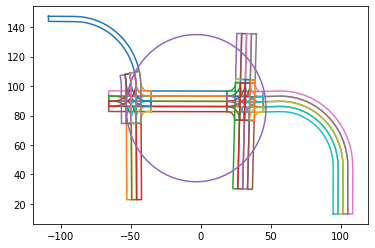

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x15a028fa0>, <shapely.geometry.polygon.Polygon object at 0x15a017490>, <shapely.geometry.polygon.Polygon object at 0x15a0155e0>, <shapely.geometry.polygon.Polygon object at 0x15a00ee20>, <shapely.geometry.polygon.Polygon object at 0x15bf09fa0>, <shapely.geometry.polygon.Polygon object at 0x15bf09160>, <shapely.geometry.polygon.Polygon object at 0x15beb2790>, <shapely.geometry.polygon.Polygon object at 0x15bea9220>, <shapely.geometry.polygon.Polygon object at 0x15bfeb670>, <shapely.geometry.polygon.Polygon object at 0x15bfe6610>, <shapely.geometry.polygon.Polygon object at 0x15bfdf760>, <shapely.geometry.polygon.Polygon object at 0x15bfdd790>, <shapely.geometry.polygon.Polygon object at 0x15c09c7f0>, <shapely.geometry.polygon.Polygon object at 0x15c096400>, <shapely.geometry.polygon.Polygon object at 0x15c07f400>, <shapely.geometry.polygon.Polygon object at 0x15c07c370>, <shapely.geometry.polygon.Polygon 

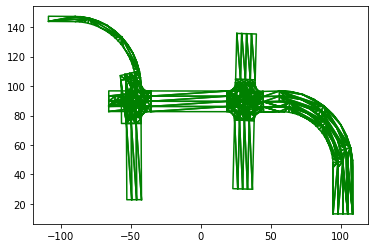

valid attribute:  ['obj0_position']
conditionAttributes attribute:  obj0_heading
valid attribute:  ['obj0_heading']
conditionAttributes attribute:  obj0_heading


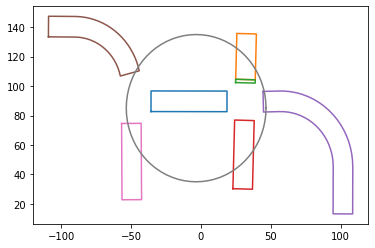

len(possibleRegions):  8


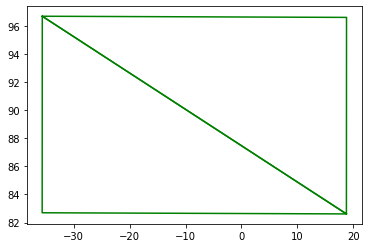

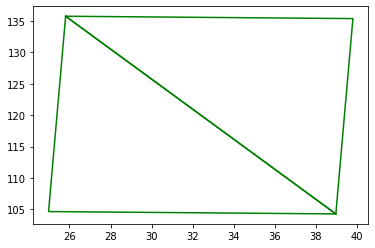

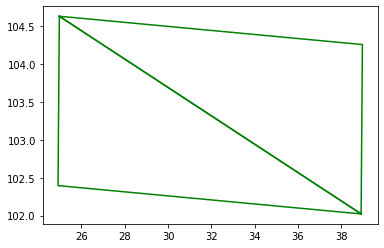

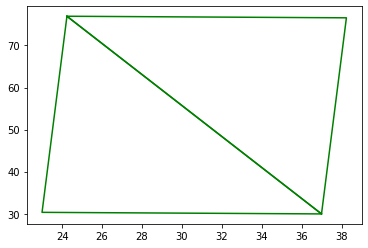

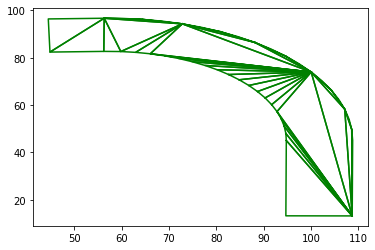

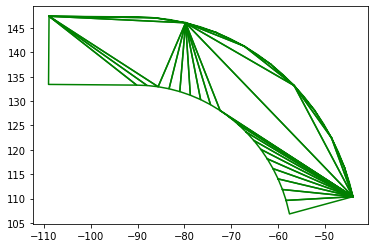

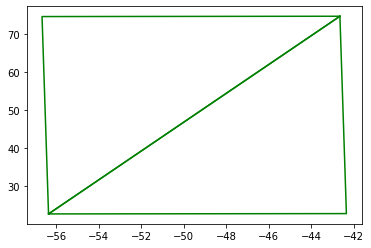

valid attribute:  ['obj1_position']


NotImplementedError: 

In [14]:
import os
import scenic
scenic_script = "./examples/carla/ICCV_Scenic_Experiments/2_agent_scenario.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

for i in range(1):
    resetScenarioDependency(scenario)
    sample = scenario.generateForQuery(verbosity=3)
    label, _ = sample
    if not validateLabel(scenario, label, debug=False):
        print("NOT VALID LABEL")
        break
    else:
        print("label is valid: ", i)



In [ ]:
print(scenario.original_objects[5].position)

In [ ]:
"""
Issue1: ahead/behind, left/right of uses the same heading angle as the referenced
        (1) As a result, position & heading are jointly dependent
        ==> what if we do not allow joint dependency between position and heading?
        This assumes that we can decouple joint dependency between the two, if exists.
        Is this true? Yes
        ==> Limitation: if many there are many jointly dependent features all at once, it may not be feasible to solve
        
        (2) an obj can have its position be dependent on its heading because its heading is the same as the 
        heading of another object to which the obj is depedent
        ==> is this only an issue with ego? because the ordering of the objects 
        ==> ==> solution: just keep the original objects ordering

Issue2: my assumption that jointly dependent and dependent relationships are disjoint is wrong
        (e.g. dependencyAnalysisTest4.scenic)
        ==> it's not possible to capture such case since the attribute contains the intermediate variable
        ==> another ordering process needs to be done within jointly dependent features based on dependence relations

Issue3: Need to check the case when multiple attributes are dependent on another attributes
        (e.g. )
        

Sorting Approach
Since the objects are listed in the order the scenario is written, 
the order in which SMT translation is to be done stays intact
The only issue now is to determine joint dependency
==> before adding to joint dependency, check whether the jointly dependent attribute is dependent on any of the
other jointly dependent attributes
"""